In [1]:
#imports of package used in the 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [2]:
X_train=pd.read_csv("X_train.csv",sep=';',index_col="Id") #_sqprice for price per square feet
y_train=pd.read_csv("y_train.csv",sep=';',index_col="Id")
random_states=pd.read_csv("500_random_states.csv",index_col=0)
#X_test=pd.read_csv("X_test.csv",sep=';',index_col="Id")
X_train_split1, X_test, y_train_split1, y_test = train_test_split(X_train,y_train, test_size=0.2,random_state=42)

In [3]:
#a function to evaluate the fit (rmse) of the prediciton
from sklearn.metrics import mean_squared_error
def evaluate_fit(y_test,predictions):
    if mean_squared_error(y_test,predictions)<0:
        rmse=np.sqrt(-1*(mean_squared_error(y_test,predictions)))
    else:
        rmse=np.sqrt(mean_squared_error(y_test,predictions))
    return rmse

In [4]:
#necessary imports: decisiontreeregressor, np,pandas, train_test_split
def ensemble_fct(random_state=42,n=20,test_size=0.2,max_features=None,max_depth=6,report_mse=False,split_states="None"):
    """This function draws subsamples of the training set, trains a tree to every subsample and generates an
    ensembles of these trees
    
    
    random_state: [None or any integer]
    n: [int] specifies how many subsamples/trees should be used
    test_size: [float (0,1)] - specifies the proportion of the training data should be used as subsample
    max_features:[int or float(0,1)] specifies how many features should be considered at splits. this is used in random forest methods 
    to decorrelate trees
    max_depth: [int] - specifies the maximum depth of the single trees
    report_mse: reports the mse of every single predictors and every ensemble
    split_states: [int, length has to match n!] specify random states if random states of sample should be controlled to reproduce the results.
    """

    #generate n random states
    
    #check whether random states for the splits are given or whether they need to be generated, and generate if necessary
    if split_states=="None":
        split_states=[]
        while len(split_states)<n:
            candidate=np.random.randint(0,2000)
            if candidate not in split_states:
                split_states.append(candidate)
    else:
        split_states=split_states
        
    #check if there is a random state for every n subsample (otherwise function breaks)
    if n>len(split_states):
        raise NameError("the length of split_states has to match n")
    
    #initialize the tree with the prespecified parameters and define a dataframe to store the forecasts of every tree
    dtree=DecisionTreeRegressor(random_state=random_state,max_depth=max_depth,max_features=max_features) #max_features=80 
    all_predictions=pd.DataFrame(index=X_test.index)
    
    #drawing n subsamples each time from tull training dataset, fitting a tree to the subsample
    #    and use the tree to make prediction for every tree
    r2_tree=[]
    for i in range(n):
        X_train_split, X_eval, y_train_split, y_eval = train_test_split(X_train_split1,y_train_split1, test_size=test_size,random_state=split_states[i])
        dtree.fit(X_train_split, y_train_split)
        all_predictions[str(i)]=dtree.predict(X_test)
        r2_tree.append(r2_score(y_test,all_predictions[str(i)].ravel()))
    
    #evaluate the fit of single tree predictions, returning contains all output variables for further use
    returning={}
    mse_tree=[]
    for i in range(len(split_states)):
        mse_t=evaluate_fit(y_test,all_predictions[str(i)])
        mse_tree.append(mse_t)
        if report_mse==True:
            print(str(i)+". Tree: "+str(mse_t))
    returning["mse_tree"]=mse_tree
    print("generated "+str(n)+" predictions")
    
    # combine the individual predictions to n ensembles (first ensemble is just single tree)
    ensemble=pd.DataFrame(index=X_test.index)
    labels=list(all_predictions.columns.values)
    ensemble["Ensemble0"]=(all_predictions["0"])
    for i in range(1,len(labels)):
        ensemble["Ensemble"+labels[i]]=ensemble["Ensemble"+str(i-1)]+all_predictions[labels[i]]
    
    #divide the ensembles by the number of trees used for the ensemble predictions
    ensemble_labels=list(ensemble.columns.values)
    counter=1
    for i in ensemble_labels:
        ensemble[i]=ensemble[i]/counter
        counter+=1
    print("generated "+str(n)+" ensembles")
    
    #evaluate the fit of ensembles
    mse_ensemble=[]
    for i in ensemble.columns.values:
        mse_e=evaluate_fit(y_test,ensemble[str(i)])
        if report_mse==True:
            print(i+": "+str(mse_e))
        mse_ensemble.append(mse_e)
    r2_ensemble=r2_score(y_test,ensemble[ensemble_labels[-1]].ravel())    
    #return a dictionary with all the relevant outputs for further use
    returning["r2_tree"]=r2_tree
    returning["r2_ensemble"]=r2_ensemble
    returning["mse_ensemble"]=mse_ensemble
    returning["trees"]=all_predictions
    returning["ensemble"]=ensemble
    returning["states"]=split_states 
    
    return returning

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


generated 80 predictions
generated 80 ensembles
R2: 0.891696490366, min rmse of prediction: 28817.0860595, number of predictors: 78


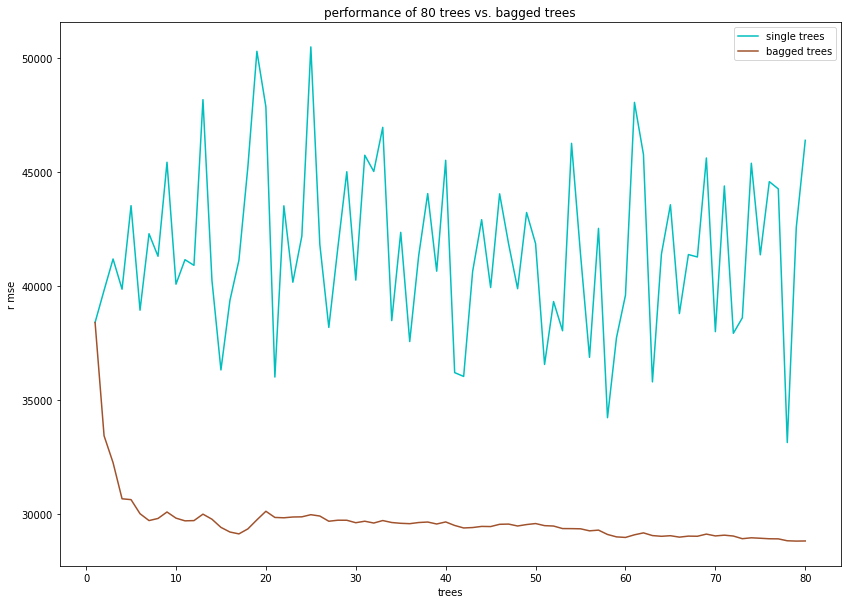

minimum of rmse:28817.0860595


In [18]:
# call the function and specify the parameters
#get random numbers
n=80
split_states=random_states["0"].values[:n]


output=ensemble_fct(random_state=42,n=80,test_size=0.33,max_depth=None,max_features=None,split_states=split_states);

#unpack the returned parameters
rmse_tree=output["mse_tree"]
rmse_ensemble=output["mse_ensemble"]
trees=output["trees"]
ensemble=output["ensemble"]
states=output["states"]
r2_tree=np.mean(output["r2_tree"])
r2_ensemble=output["r2_ensemble"]
# print the minimum rmse of all ensembles and the number of trees used
print("R2: "+str(r2_ensemble)+", min rmse of prediction: "+str(min(rmse_ensemble))+", number of predictors: "+str(rmse_ensemble.index(min(rmse_ensemble))))##visualization of the performance of simple ensemble and the individual trees

##visualization of the performance of simple ensemble and the individual trees
plt.figure(figsize=(14,10))
plt.plot(range(1,len(rmse_tree)+1),rmse_tree,color="c", label="single trees")
plt.plot(range(1,len(rmse_tree)+1),rmse_ensemble,color="sienna",label="bagged trees")
plt.ylabel("r mse")
plt.xlabel("trees")
plt.legend()
plt.title("performance of "+str(len(rmse_tree))+" trees vs. bagged trees")

rmse_min = min(rmse_ensemble)

#to visualize the local minimum in the graph
#xpos = rmse_ensemble.index(rmse_min)
#xmin = range(1,len(rmse_tree)+1)[xpos]
#plt.annotate('min', xy=(xmin, rmse_min-15), xytext=(xmin, rmse_min+50),arrowprops=dict(facecolor='black', shrink=0.05))

#to save the figure, specify name.png
#plt.savefig("simple_ensemble_80trees_performance.png")
plt.show()
print("minimum of rmse:"+str(rmse_min))

In [5]:
#necessary imports: decisiontreeregressor, np,pandas, train_test_split

def ensemble_weights_fct(random_state=42,n=50,test_size=0.2,max_features=None,max_depth=8,report_mse=False,split_states="None"):
    """
    a function to generate ensembles with higher weights to presumably better predicitons
    function takes the same parameters as normal ensemble fct.

    """
    #generate n random states
    
    #check whether random states for the splits are given or whether they need to be generated, and generate if necessary
    if split_states=="None":
        split_states=[]
        while len(split_states)<n:
            candidate=np.random.randint(0,2000)
            if candidate not in split_states:
                split_states.append(candidate)
    else:
        split_states=split_states
        
    #check if there is a random state for every n subsample (otherwise function breaks)
    if n>len(split_states):
        raise NameError("the length of split_states has to match n")

    #subsample the training dataset, fit a tree to every subsample, predict and evaluate the 
    #   subsampling-fit as basis for the weights and later use the test set to make actual predictions for each subsample
    dtree=DecisionTreeRegressor(random_state=random_state,max_depth=max_depth,max_features=max_features) #max_features=80 
    all_predictions=pd.DataFrame(index=X_test.index)
    weights=[]
    mse_total=[]
    inverse_mse=[]
    for i in range(n):
        X_train_split, X_eval, y_train_split, y_eval = train_test_split(X_train_split1,y_train_split1, test_size=test_size,random_state=split_states[i])
        dtree.fit(X_train_split, y_train_split)
        all_predictions[str(i)]=dtree.predict(X_test)
        weight_eval=dtree.predict(X_eval)
        fit=evaluate_fit(y_eval,weight_eval)
        mse_total.append(fit)
        inverse_mse.append(1/(fit*fit))

    #compute the relative weights for each predictor and apply weights to predictors
    total=sum(inverse_mse)
    for i in inverse_mse:
        weights.append(i/total)
    labels=list(all_predictions.columns.values)
    counter=0
    for i in labels:
        all_predictions[i]=all_predictions[i]*weights[counter]
        counter+=1
        
    #calculate the ensemble dataset by adding all weighted predictors
    returning={}
    ensemble=pd.DataFrame(index=X_test.index)
    ensemble["Ensemble"]=all_predictions["0"]
    for i in labels[1:]:
        ensemble["Ensemble"]=(ensemble["Ensemble"]+all_predictions[i])
    #evaluate the fit of the ensemble and return the fit
    print("generated ensemble from  "+str(n)+" weighted trees")
    returning["mse"]= evaluate_fit(y_test,ensemble["Ensemble"])
    returning["r2"]=r2_score(y_test,ensemble["Ensemble"].ravel())
    returning["weights"]=weights
    returning["mse_total"]=mse_total
    return returning

In [6]:
def ensemble_compare(n=40,random_state=None,test_size=0.2,max_depth=8,max_features=None,split_states="None"):
    """
    a function to compare the ensemble methods, with the same random split_states (used in simple ensemble)
    and visualize the performance in a graph
    
    parameters are the same as in the simple ensemble fct.
    
    
    """
    # generate predictions from a simple ensemble and return the random states used
    output=ensemble_fct(random_state=random_state,n=n,test_size=test_size,max_depth=max_depth,max_features=max_features,split_states=split_states);
    rmse_tree=output["mse_tree"]
    rmse_ensemble=output["mse_ensemble"]
    trees=output["trees"]
    ensemble=output["ensemble"]
    states=output["states"]
    r2_tree=np.mean(output["r2_tree"])
    r2_simple=output["r2_ensemble"]
    #n=output["n"]
    print("min rmse of prediction: "+str(min(rmse_ensemble))+" number of predictors: "+str(rmse_ensemble.index(min(rmse_ensemble))))

    mse_weighted=[]
    mse_tree=[]
    compare_states=[]
    #initialize the tree regressor
    dtree=DecisionTreeRegressor(random_state=random_state,max_depth=max_depth,max_features=max_features)
    
    #generate n weighted ensembles and make a list of the performance each step
    for i in range(0,n):
        compare_states.append(states[i])
        output2=ensemble_weights_fct(n=i+1,max_features=max_features,split_states=states,random_state=random_state,test_size=test_size,max_depth=max_depth)
        mse_w=output2["mse"]
        mse_weighted.append(mse_w)
        X_train_split, X_eval, y_train_split, y_eval = train_test_split(X_train_split1,y_train_split1, test_size=test_size,random_state=states[i-1])
        dtree.fit(X_train_split, y_train_split)
        prediction=dtree.predict(X_test)
        mse_tree.append(evaluate_fit(y_test,prediction))
    r2_weighted=output2["r2"]
    
    # visualize the performance of the single trees and ensemble methods, and save the graphic
    plt.figure(figsize=(14,10))
    plt.plot(range(1,len(mse_tree)+1),rmse_tree,color="c",label="single trees")
    plt.plot(range(1,len(rmse_tree)+1),rmse_ensemble,color="sienna",linestyle="--",label="bagged trees")
    plt.plot(range(1,len(mse_tree)+1),mse_weighted,color="navy",label="weighted ensemble")
    plt.ylabel("rmse")
    plt.xlabel("trees")
    plt.legend()
    plt.title("performance of tree methods with "+str(len(mse_tree))+" trees")
    rmse_simple_min = min(rmse_ensemble)
    rmse_weighted_min = min(mse_weighted)
    #plt.savefig("fixstate_comparison_sampling_uncorr_ensem_"+str(n)+"trees_depth"+str(max_depth)+".png")
    plt.show()
    print("minimum rmse simple: "+str(rmse_simple_min))
    print("minimum rmse weighted: "+str(rmse_weighted_min))
    print("Mean R2 trees: "+str(r2_tree))
    print("R2 simpleEnsemble: "+str(r2_simple))
    print("R2 weightedEnsemble: "+str(r2_weighted))
    #return mse_weighted
    #return rmse_ensemble

C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


generated 80 predictions
generated 80 ensembles
min rmse of prediction: 28817.086059498917 number of predictors: 78


C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if sys.path[0] == '':


generated ensemble from  1 weighted trees
generated ensemble from  2 weighted trees
generated ensemble from  3 weighted trees
generated ensemble from  4 weighted trees
generated ensemble from  5 weighted trees
generated ensemble from  6 weighted trees
generated ensemble from  7 weighted trees
generated ensemble from  8 weighted trees
generated ensemble from  9 weighted trees
generated ensemble from  10 weighted trees
generated ensemble from  11 weighted trees
generated ensemble from  12 weighted trees
generated ensemble from  13 weighted trees
generated ensemble from  14 weighted trees
generated ensemble from  15 weighted trees
generated ensemble from  16 weighted trees
generated ensemble from  17 weighted trees
generated ensemble from  18 weighted trees
generated ensemble from  19 weighted trees
generated ensemble from  20 weighted trees
generated ensemble from  21 weighted trees
generated ensemble from  22 weighted trees
generated ensemble from  23 weighted trees
generated ensemble f

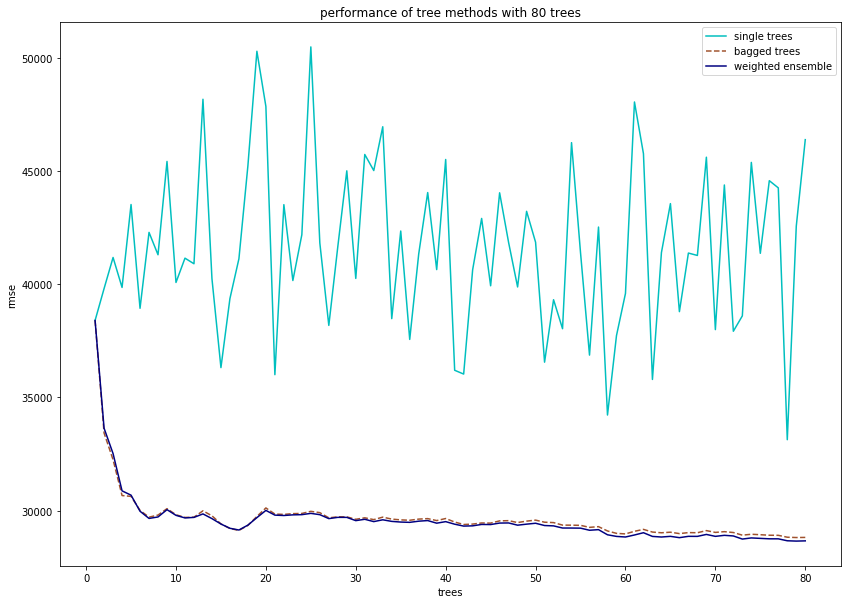

minimum rmse simple: 28817.086059498917
minimum rmse weighted: 28660.212125076767
Mean R2 trees: 0.773058035892706
R2 simpleEnsemble: 0.8916964903662161
R2 weightedEnsemble: 0.8928386173761604


In [7]:
n=80
split_states=random_states["0"].values[:n]
ensemble_compare(n=n,random_state=42,test_size=0.33,max_depth=None,max_features=None,split_states=split_states)

In [8]:
from sklearn.ensemble import RandomForestRegressor

In [9]:
def rf_ensemble_compare(n=40,random_state=None,test_size=0.2,max_depth=8,max_features=None,split_states="None"):
    """
    a function to compare the ensemble methods, with the same random split_states (used in simple ensemble)
    and visualize the performance in a graph
    
    parameters are the same as in the simple ensemble fct.
    
    
    """
    
    dtree=DecisionTreeRegressor(random_state=None,max_depth=max_depth,max_features="sqrt")
    all_predictions1=pd.DataFrame(index=X_test.index)
    
    #drawing n subsamples each time from tull training dataset, fitting a tree to the subsample
    #    and use the tree to make prediction for every tree
    mse_trf=[]
    for i in range(n):
        dtree.fit(X_train_split1, y_train_split1)
        all_predictions1[str(i)]=dtree.predict(X_test)
        mse_trf.append(evaluate_fit(y_test,all_predictions1[str(i)].ravel()))

    


    
    # combine the individual predictions to n ensembles (first ensemble is just single tree)
    ensemble_rf=pd.DataFrame(index=X_test.index)
    labels=list(all_predictions1.columns.values)
    ensemble_rf["Ensemble0"]=(all_predictions1["0"])
    for i in range(1,len(labels)):
        ensemble_rf["Ensemble"+labels[i]]=ensemble_rf["Ensemble"+str(i-1)]+all_predictions1[labels[i]]
    
    #divide the ensembles by the number of trees used for the ensemble predictions
    ensemble_rf_labels=list(ensemble_rf.columns.values)
    counter=1
    for i in ensemble_rf_labels:
        ensemble_rf[i]=ensemble_rf[i]/counter
        counter+=1
    print("generated "+str(n)+" ensembles")
    
    #evaluate the fit of ensembles
    mse_rf=[]
    r2_rf=[]
    for i in ensemble_rf.columns.values:
        mse_randf=evaluate_fit(y_test,ensemble_rf[str(i)])
        mse_rf.append(mse_randf)
        r2_rf.append(r2_score(y_test,ensemble_rf[ensemble_rf_labels[-1]].ravel()))
    print("Rf-mse:"+str(mse_rf[-1]))    
    # generate predictions from a simple ensemble and return the random states used
    output=ensemble_fct(random_state=random_state,n=n,test_size=test_size,max_depth=max_depth,max_features=max_features,split_states=split_states);
    rmse_tree=output["mse_tree"]
    rmse_ensemble=output["mse_ensemble"]
    trees=output["trees"]
    ensemble=output["ensemble"]
    states=output["states"]
    r2_tree=np.mean(output["r2_tree"])
    r2_simple=output["r2_ensemble"]
    #n=output["n"]
    print("Ensemble:min rmse of prediction: "+str(min(rmse_ensemble))+" number of predictors: "+str(rmse_ensemble.index(min(rmse_ensemble))))
    
    
    
    mse_weighted=[]
    mse_tree=[]
    compare_states=[]
    #initialize the tree regressor
    dtree=DecisionTreeRegressor(random_state=random_state,max_depth=max_depth,max_features=max_features)
    
    #generate n weighted ensembles and make a list of the performance each step
    for i in range(0,n):
        compare_states.append(states[i])
        output2=ensemble_weights_fct(n=i+1,max_features=max_features,split_states=states,random_state=random_state,test_size=test_size,max_depth=max_depth)
        mse_w=output2["mse"]
        mse_weighted.append(mse_w)
        X_train_split, X_eval, y_train_split, y_eval = train_test_split(X_train_split1,y_train_split1, test_size=test_size,random_state=states[i-1])
        dtree.fit(X_train_split, y_train_split)
        prediction=dtree.predict(X_test)
        mse_tree.append(evaluate_fit(y_test,prediction))
    r2_weighted=output2["r2"]
    
    # visualize the performance of the single trees and ensemble methods, and save the graphic
    plt.figure(figsize=(14,10))
    plt.plot(range(1,len(mse_tree)+1),rmse_tree,color="c",linestyle="--",label="single trees")
    plt.plot(range(1,len(mse_tree)+1),mse_trf,color="olive",label="rf trees")
    plt.plot(range(1,len(rmse_tree)+1),rmse_ensemble,linestyle="--",color="sienna",label="bagged trees")
    plt.plot(range(1,len(mse_tree)+1),mse_weighted,linestyle=(0, (1, 1)),color="navy",label="weighted ensemble")
    plt.plot(range(1,len(mse_tree)+1),mse_rf,color="darkslategrey",label="Random Forest")
    plt.ylabel("rmse")
    plt.xlabel("trees")
    plt.legend()
    plt.title("performance of tree methods with "+str(len(mse_tree))+" trees")
    rmse_simple_min = min(rmse_ensemble)
    rmse_weighted_min = min(mse_weighted)
    rmse_rf_min=min(mse_rf)
    #plt.savefig("rftree_forest_comparison_nobootstrap_ensem_"+str(n)+"trees_depth"+str(max_depth)+".png")
    plt.show()
    print("minimum rmse simple: "+str(rmse_simple_min))
    print("minimum rmse weighted: "+str(rmse_weighted_min))
    print("minimum rmse rf: "+str(rmse_rf_min))
    print("Mean R2 trees: "+str(r2_tree))
    print("R2 simpleEnsemble: "+str(r2_simple))
    print("R2 weightedEnsemble: "+str(r2_weighted))

generated 80 ensembles
Rf-mse:30899.348796358187


C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


generated 80 predictions
generated 80 ensembles
Ensemble:min rmse of prediction: 28817.086059498917 number of predictors: 78
generated ensemble from  1 weighted trees


C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if sys.path[0] == '':


generated ensemble from  2 weighted trees
generated ensemble from  3 weighted trees
generated ensemble from  4 weighted trees
generated ensemble from  5 weighted trees
generated ensemble from  6 weighted trees
generated ensemble from  7 weighted trees
generated ensemble from  8 weighted trees
generated ensemble from  9 weighted trees
generated ensemble from  10 weighted trees
generated ensemble from  11 weighted trees
generated ensemble from  12 weighted trees
generated ensemble from  13 weighted trees
generated ensemble from  14 weighted trees
generated ensemble from  15 weighted trees
generated ensemble from  16 weighted trees
generated ensemble from  17 weighted trees
generated ensemble from  18 weighted trees
generated ensemble from  19 weighted trees
generated ensemble from  20 weighted trees
generated ensemble from  21 weighted trees
generated ensemble from  22 weighted trees
generated ensemble from  23 weighted trees
generated ensemble from  24 weighted trees
generated ensemble 

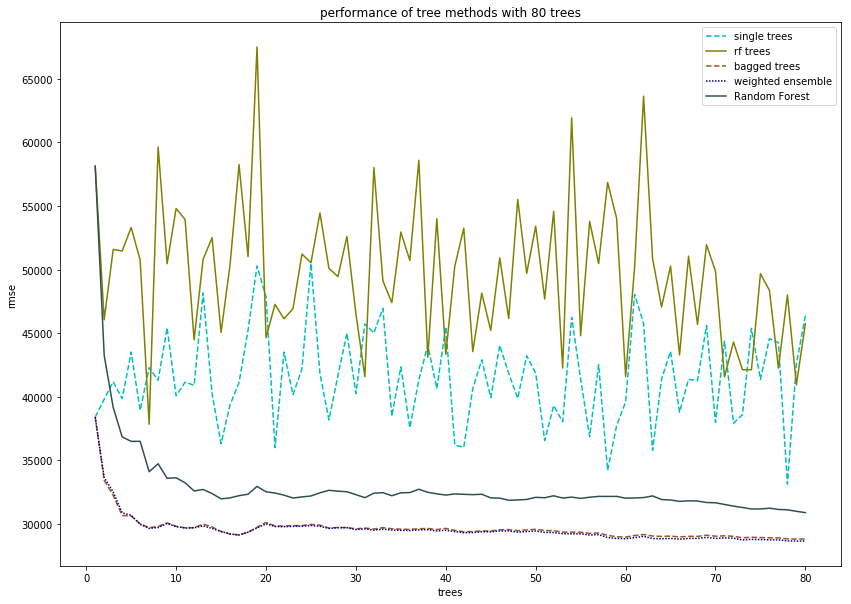

minimum rmse simple: 28817.086059498917
minimum rmse weighted: 28660.212125076767
minimum rmse rf: 30899.348796358187
Mean R2 trees: 0.773058035892706
R2 simpleEnsemble: 0.8916964903662161
R2 weightedEnsemble: 0.8928386173761604


In [10]:
n=80
split_states=random_states["0"].values[:n]
rf_ensemble_compare(n=n,random_state=42,test_size=0.33,max_depth=None,max_features=None,split_states=split_states)

generated 200 ensembles
Rf-mse:31497.51814936877


C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


generated 200 predictions
generated 200 ensembles
Ensemble:min rmse of prediction: 28752.200976706114 number of predictors: 137
generated ensemble from  1 weighted trees


C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if sys.path[0] == '':


generated ensemble from  2 weighted trees
generated ensemble from  3 weighted trees
generated ensemble from  4 weighted trees
generated ensemble from  5 weighted trees
generated ensemble from  6 weighted trees
generated ensemble from  7 weighted trees
generated ensemble from  8 weighted trees
generated ensemble from  9 weighted trees
generated ensemble from  10 weighted trees
generated ensemble from  11 weighted trees
generated ensemble from  12 weighted trees
generated ensemble from  13 weighted trees
generated ensemble from  14 weighted trees
generated ensemble from  15 weighted trees
generated ensemble from  16 weighted trees
generated ensemble from  17 weighted trees
generated ensemble from  18 weighted trees
generated ensemble from  19 weighted trees
generated ensemble from  20 weighted trees
generated ensemble from  21 weighted trees
generated ensemble from  22 weighted trees
generated ensemble from  23 weighted trees
generated ensemble from  24 weighted trees
generated ensemble 

generated ensemble from  191 weighted trees
generated ensemble from  192 weighted trees
generated ensemble from  193 weighted trees
generated ensemble from  194 weighted trees
generated ensemble from  195 weighted trees
generated ensemble from  196 weighted trees
generated ensemble from  197 weighted trees
generated ensemble from  198 weighted trees
generated ensemble from  199 weighted trees
generated ensemble from  200 weighted trees


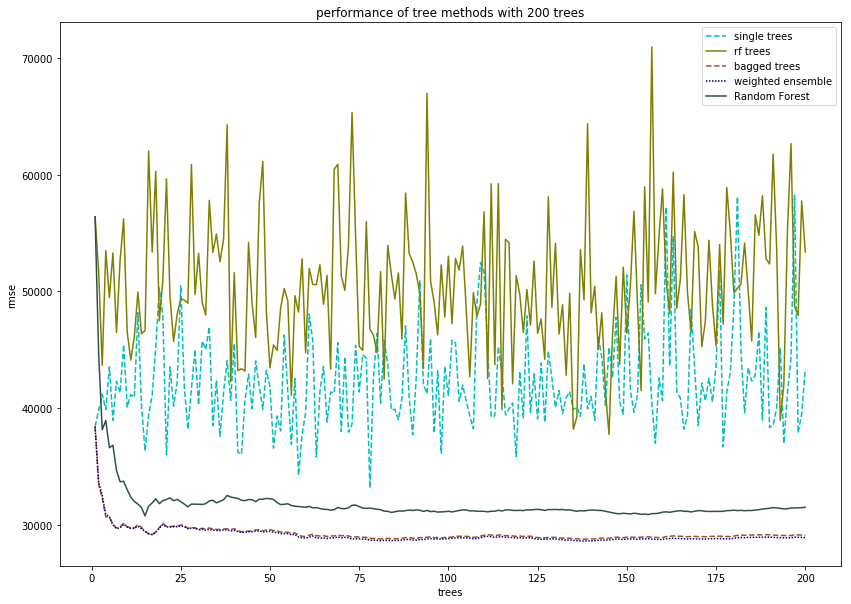

minimum rmse simple: 28752.200976706114
minimum rmse weighted: 28590.999066931843
minimum rmse rf: 30755.89835132568
Mean R2 trees: 0.7648095636229332
R2 simpleEnsemble: 0.8896850654910199
R2 weightedEnsemble: 0.8912053787992915


In [11]:
n=200
split_states=random_states["0"].values[:n]
rf_ensemble_compare(n=n,random_state=42,test_size=0.33,max_depth=None,max_features=None,split_states=split_states)